In [1]:
import numpy as np
import gym
import seaborn as sns
import pandas as pd
import tensorflow as tf
sns.set()

***
### $Q$-learning as a Regression Problem

When we first learned about $Q$-learning, we used the Bellman equation to learn the $Q$ function:
$$
Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha \left( r_t + (1-d_t)\gamma \max_{a_{t+1}} \left( Q(s_{t+1}, a_{t+1}) \right) - Q(s_t, a_t) \right)
$$

Compare this to gradient descent for a regression problem:
$$
\theta \gets \theta - \alpha 2 \left( \hat{y} - y \right) \nabla_\theta \hat{y}
$$

These methods are essentially analogous: we update parameters about our function in a manner proportional to the difference between our prediction and the 'true' value. The difference for tabular $Q$-learning is that we essentially have a different parameter for each state-action pair. If we think about our loss function, then, we have
$$
L(\theta) = \frac{1}{2} \left( r_t + (1-d_t)\gamma \max_{a_{t+1}} \left( Q(s_{t+1}, a_{t+1}) \right) - Q(s_t, a_t) \right)^2
$$

which we can minimize using gradient descent.

### FrozenLake with Tensorflow

Before diving deep into using techniques like deep neural networks, I want to show you how we might do $Q$-learning in tensorflow using the same `FrozenLake-v0` environment from earlier.

We make many changes: rather than calling functions like `act()` and `update()`, instead we make this functionality available as a tensorflow op that is a member variable of the class. This way, we can do things like `sess.run(agent.update, ...` to update, rather than call `agent.update()`.

Tensorflow requires a different kind of understanding of a program. Every statement in a normal python program (`if-else` blocks, assignment, indexing an array, etc) should be converted into an equivalent tensorflow op, so that the entire computation graph represents the program in an abstract way. For now, this may seem unnecessarily obtuse, but the truth is that when we get into more advanced techniques, it will be advantageous for us to define as much of the program in tensorflow as possible.

In [2]:
class Agent:
    def __init__(self, num_states, num_actions, 
                 epsilon_i=1.0, 
                 epsilon_f=0.0, 
                 n_epsilon=0.1, 
                 alpha=0.5, 
                 gamma = 0.95):
        
        tf.reset_default_graph()
        
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.epsilon = tf.get_variable("epsilon", initializer=tf.constant(self.epsilon_i))
        self.n_epsilon = n_epsilon
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.Q = tf.get_variable("Q", initializer=tf.zeros(shape=(num_states, num_actions), dtype=tf.float32))

        self.s_t_ph = tf.placeholder(shape=(), dtype=tf.int32, name="state")
        self.a_t_ph = tf.placeholder(shape=(), dtype=tf.int32, name="action")
        self.r_t_ph = tf.placeholder(shape=(), dtype=tf.float32, name="reward")
        self.s_t_next_ph = tf.placeholder(shape=(), dtype=tf.int32, name="next_state")
        self.d_t_ph = tf.placeholder(shape=(), dtype=tf.float32, name="done")
        self.n_ph = tf.placeholder(shape=(), dtype=tf.float32, name="n")

        self.decay_epsilon = self.decay_epsilon_tf(self.n_ph)
        self.act = self.act_tf(self.s_t_ph)
        self.update = self.update_tf(self.s_t_ph, self.a_t_ph, self.r_t_ph, self.s_t_next_ph, self.d_t_ph)

        
    def decay_epsilon_tf(self, n):
        return tf.assign(self.epsilon, tf.maximum(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f)))
    
    def act_tf(self, s_t):
        return tf.cond(tf.random_uniform(shape=(), minval=0, maxval=1, dtype=tf.float32) < self.epsilon,
                      lambda: tf.random_uniform(shape=(), minval=0, maxval=self.num_actions, dtype=tf.int32),
                      lambda: tf.argmax(self.Q[s_t], output_type=tf.int32))
    
    def update_tf(self, s_t, a_t, r_t, s_t_next, d_t):
        Q_next = tf.reduce_max(self.Q[s_t_next])
        TD = r_t + (1-d_t)*self.gamma*Q_next
        loss = 0.5*(self.Q[s_t, a_t] - tf.stop_gradient(TD))**2
        return tf.train.GradientDescentOptimizer(self.alpha).minimize(loss)

In [3]:
def train(env, agent, T=100000):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    rewards = []
    episode_rewards = 0
    
    s_t = env.reset()
    
    for t in range(T):
        if t%1000 == 0:
            print(f'{100*t/T}%', end='\r')
        a_t = sess.run(agent.act, 
                       feed_dict={
                           agent.s_t_ph:s_t
                       }
                      )
    

        s_t_next, r_t, d_t, info = env.step(a_t)
        sess.run([agent.update, agent.decay_epsilon], 
                 feed_dict={
                     agent.s_t_ph:s_t,
                     agent.a_t_ph:a_t,
                     agent.r_t_ph:r_t,
                     agent.s_t_next_ph:s_t_next,
                     agent.d_t_ph:d_t,
                     agent.n_ph:t/T,
                 }
                )
        s_t = s_t_next
        episode_rewards += r_t
        
        if d_t:
            rewards.append(episode_rewards)
            episode_rewards = 0
            s_t = env.reset()

    sess.close()
    return rewards

In [4]:
def plot(data, window=100):
    sns.lineplot(
        data=data.rolling(window=window).mean()[window-1::window]
    )

In [5]:
env = gym.make("FrozenLake-v0")
num_states = env.observation_space.n
num_actions = env.action_space.n
agent = Agent(num_states, num_actions, alpha=0.8, gamma=0.95, epsilon_i=1.0, epsilon_f=0.0)

rewards = train(env, agent, T=100000)

Instructions for updating:
Colocations handled automatically by placer.


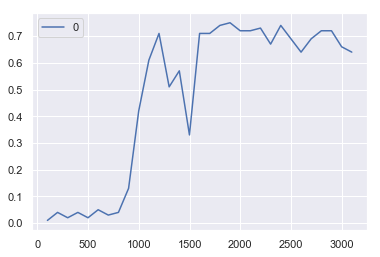

In [6]:
plot(pd.DataFrame(rewards))